In [1]:
import FalseColor_methods as fc 
from FCdataobject import DataObject
import h5py as hp
import numpy as np
import tifffile as tf
import os 
import json
import glob
import skimage.filters as filt
import cv2
import time
import copy
import skimage.morphology as morph
from scipy import stats
import skimage.feature as feat
import skimage.exposure as ex
import skimage.measure as me
import scipy.ndimage as nd
import skimage.segmentation as sg
import skimage.util as util
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
import importlib

importlib.reload(fc)

<module 'FalseColor_methods' from '/Users/robertserafin/Desktop/Image_analysis_codebase/False Coloring/FalseColor_methods.py'>

In [2]:
channelIDs = ['s00', 's01']

In [3]:
def make_blocks_vectorized(x,d,block_depth = 8):
    p,m,n = x.shape
    print(p)
    #reshape into smaller 3D arrays 
    blocks =  x.reshape(-1,m//d,d,n//d,d).transpose(1,3,0,2,4).reshape(-1,p,d,d)
    block_set = []
    for j in range(len(blocks)):
        for i in range(p//block_depth):
            #chunk arrays into workable pieces
#             print(i*block_depth,(i+1)*block_depth)
            block_set.append(blocks[j,i*block_depth:(i+1)*block_depth,:,:])
    return block_set

def unmake_blocks_vectorized(x,d,m,n):    
    return np.concatenate(x).reshape(m//d,n//d,d,d).transpose(0,2,1,3).reshape(m,n)



In [4]:
def ViewImage(Images,title=None,do_hist = False,figsize = (6,4), range_min=0,range_max=None):
    if do_hist:
        f,ax = plt.subplots(ncols = 2,figsize = figsize)
        ax[0].imshow(Images)
        ax[0].set_title('Image')
        if range_max is None:
            range_max = Images.max()
        ax[1].hist(Images[Images != 0].ravel(),256,[range_min,range_max])
        ax[1].set_title('Histogram')
        if title is not None:
            f.suptitle(title)
    else:
        f,ax = plt.subplots(figsize=figsize)
        ax.imshow(Images)
        if title is not None:
            ax.set_title(title)
    return f,ax

def convert_8bit(img):
    return (img/256).astype(np.uint8)

def dilation_method(img):
    el = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    dilated_img = cv2.dilate(img,el)
    return dilated_img

def getPropsDataFrame(properties):
    propsdict = {}
    for i,z in enumerate(properties):
        propsdict[i] = {'label':z.label,
                         'area':z.area,
                         'bbox':z.bbox,
                         'centroid':z.centroid}
    data = pd.DataFrame.from_dict(propsdict,orient='index',columns=['label','area','bbox','centroid'])
    return data

def getImageCutout(Image,bbox):
    xstart,xstop = bbox[1],bbox[3]
    ystart,ystop = bbox[0],bbox[2]
    return Image[xstart:xstop,ystart:ystop]

def tophat_filter(image,size=31):
    kernel = (size,size)
    el = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,kernel)
    return cv2.morphologyEx(image,cv2.MORPH_TOPHAT,el)

def sk_tophat(image):
    el = morph.disk(31)
    return morph.white_tophat(image,selem=el)

def filter_and_equalize(Image,kernel_size = 25,convert=True):
    z = tophat_filter(Image)
    
    z = ex.equalize_adapthist(z,kernel_size=kernel_size)
#     z = execute_clahe(z)
    if convert:
        return util.img_as_uint(z)
    else:
        return z
    
def execute_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=8.0, tileGridSize=(8,8))
    cl1 = clahe.apply(img)
    return cl1
    
def preProcess_withCLAHE(images, channelID, nuclei_thresh = 50, cyto_thresh = 500):

    channel_parameters = {'s00' : {'thresh' : 50},
                          's01' : {'thresh' : 150}}


    #parameters for background subtraction
    thresh = channel_parameters[channelID]['thresh']
    images -= thresh
    
    images = tophat_filter(images)

    images =  np.power(images,0.85)

    image_mean = np.mean(images[images>thresh])*8

    processed_images = images*(65535/image_mean)*(255/65535)

    processed_images[processed_images < 0] = 1
    
    processed_images = execute_clahe(processed_images.astype(np.uint8))

    return processed_images

def falseColorCLAHE(imageSet,channelIDs=['s00','s01'],output_dtype= np.uint8):
    """
    expects input imageSet data to be structured in the same way as in the FCdataobject

    """
    # print(type(imageSet))

    beta_dict = {'cytoplasm' : {'K' : 0.008,
                              'R' : 0.300,
                              'G' : 1.000,
                              'B' : 0.860,
                              'thresh' : 500},
                's01' : {'K' : 0.008,
                              'R' : 0.350,
                              'G' : 1.0,
                              'B' : 0.860,
                              'thresh' : 500},
                 'nuclei' : {'K' : 0.017,
                             'R' : 0.544,
                             'G' : 1.000,
                             'B' : 0.30,
                             'thresh' : 50},
                's00' : {'K' : 0.017,
                             'R' : 0.544,
                             'G' : 1.000,
                             'B' : 0.10,
                             'thresh' : 50}}

    constants_nuclei = beta_dict[channelIDs[0]]
    k_nuclei = constants_nuclei['K']

    constants_cyto = beta_dict[channelIDs[1]]
    k_cytoplasm= constants_cyto['K']
     
    nuclei = preProcess_withCLAHE(imageSet[:,:,0],channelIDs[0])
    cyto = preProcess_withCLAHE(imageSet[:,:,1],channelIDs[1])

    RGB_image = np.zeros((nuclei.shape[0],nuclei.shape[1],3))
      
    R = np.multiply(np.exp(-constants_cyto['R']*k_cytoplasm*cyto),
                                    np.exp(-constants_nuclei['R']*k_nuclei*nuclei))

    G = np.multiply(np.exp(-constants_cyto['G']*k_cytoplasm*cyto),
                                    np.exp(-constants_nuclei['G']*k_nuclei*nuclei))

    B = np.multiply(np.exp(-constants_cyto['B']*k_cytoplasm*cyto),
                                    np.exp(-constants_nuclei['B']*k_nuclei*nuclei))

    RGB_image[:,:,0] = (R*255)
    RGB_image[:,:,1] = (G*255)
    RGB_image[:,:,2] = (B*255)
    return RGB_image.astype(output_dtype)

def preProcess(images, channelID, nuclei_thresh = 50, cyto_thresh = 500):

    channel_parameters = {'s00' : {'thresh' : 50},
                          's01' : {'thresh' : 150}}


    #parameters for background subtraction
    thresh = channel_parameters[channelID]['thresh']
    images -= thresh
    images[images < 0] = 0

    images =  np.power(images,0.85)


    image_mean = np.mean(images[images>thresh])*8

    processed_images = images*(65535/image_mean)*(255/65535)

    return processed_images

tophat_runnable = {'runnable': tophat_filter,'kwargs':{'size':31}}
falseColor_runnable = {'runnable' : fc.falseColor, 'kwargs' : {'channelIDs':channelIDs}}
preprocess_runnable = {'runnable' : fc.preProcess, 'kwargs' : None}
combine_runnable = {'runnable' : fc.combineFalseColoredChannels, 'args' : None}
adaptive_runnable = {'runnable' : fc.adaptiveBinary, 'kwargs': {'blocksize':300}}
dilation_runnable = {'runnable':dilation_method,'kwargs':None}
filter_equal_runnable= {'runnable':filter_and_equalize,'kwargs':None}
falseCLAHE_runnable = {'runnable': falseColorCLAHE,'kwargs':{'channelIDs':channelIDs}}

In [5]:
datapath = os.path.join(os.getcwd(),'h5_sample_data')
datafile = os.path.join(datapath,'data-f0.h5')

testData = DataObject(directory=datapath)
testData.setupH5data(folder=datapath)
testData.imageSet[:,:,:,0].shape
large_nuclei = copy.deepcopy(testData.imageSet[:,:,:,0])
large_cyto = copy.deepcopy(testData.imageSet[:,:,:,1])


['__DATA_TYPES__', 's00', 's01', 't00000']
(717, 1025, 1025, 2)


In [6]:
testData.imageSet.shape

(717, 1025, 1025, 2)

In [7]:
trial_nuclei = copy.deepcopy(large_nuclei[:40])
trial_cyto = copy.deepcopy(large_cyto[:40])

In [8]:
trial_set = np.stack((trial_nuclei,trial_cyto),axis=-1)
trial_set.shape

(40, 1025, 1025, 2)

In [ ]:
t0 = time.time()
pseudo_clahe = testData.processImages(falseCLAHE_runnable,imageSet=copy.deepcopy(trial_set))
print('runtime:',time.time()-t0)

In [9]:
pseudo_colored_raw = testData.processImages(falseColor_runnable,imageSet = copy.deepcopy(trial_set))

/Users/robertserafin/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/robertserafin/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<function falseColor at 0x1c2ce0d158> {'channelIDs': ['s00', 's01']} (40, 1025, 1025, 2)


/Users/robertserafin/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:131: UserWarning: Possible sign loss when converting negative image of type int16 to positive image of type uint16.
  .format(dtypeobj_in, dtypeobj_out))
/Users/robertserafin/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int16 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/Users/robertserafin/anaconda3/lib/python3.6/site-packages/skimage/exposure/exposure.py:351: RuntimeWarning: invalid value encountered in true_divide
  image = (image - imin) / float(imax - imin)
/Users/robertserafin/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:131: UserWarning: Possible sign loss when converting negative image of type int16 to positive image of type uint16.
  .format(dtypeobj_in, dtypeobj_out))
/Users/robertserafin/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converti

In [10]:
t0 = time.time()
nuclei_equalized = testData.processImages(filter_equal_runnable,imageSet=trial_nuclei)
print('runtime: ',time.time()-t0)

<function filter_and_equalize at 0x1c2ead99d8> None (40, 1025, 1025)
runtime:  6.816482782363892


In [11]:
combined_clahe = np.stack((nuclei_equalized[0],trial_cyto),axis=-1)
combined_clahe = combined_clahe

In [12]:
false_clahe = testData.processImages(falseColor_runnable,imageSet=combined_clahe)

<function falseColor at 0x1c2ce0d158> {'channelIDs': ['s00', 's01']} (40, 1025, 1025, 2)


<IPython.core.display.Javascript object>


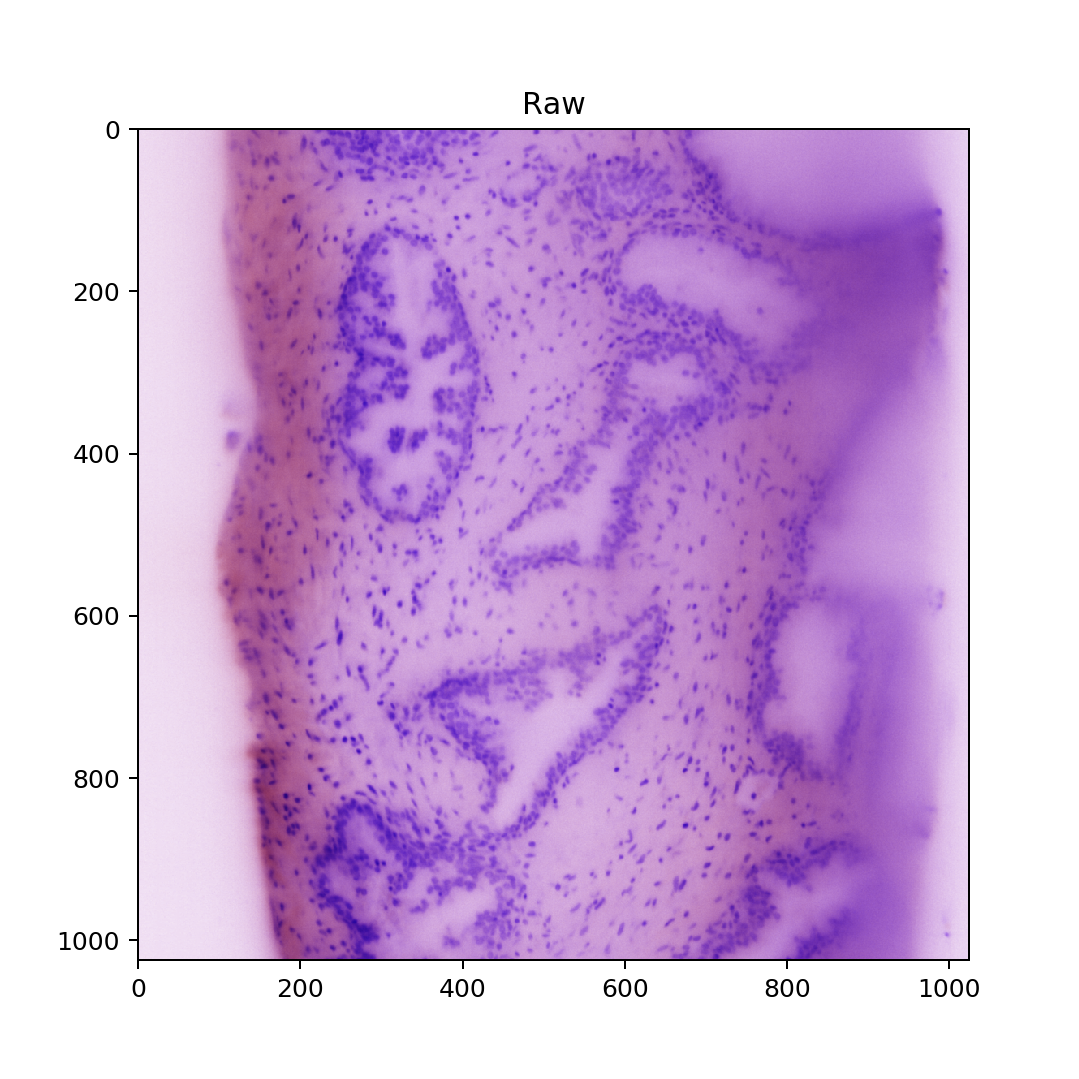

<IPython.core.display.Javascript object>


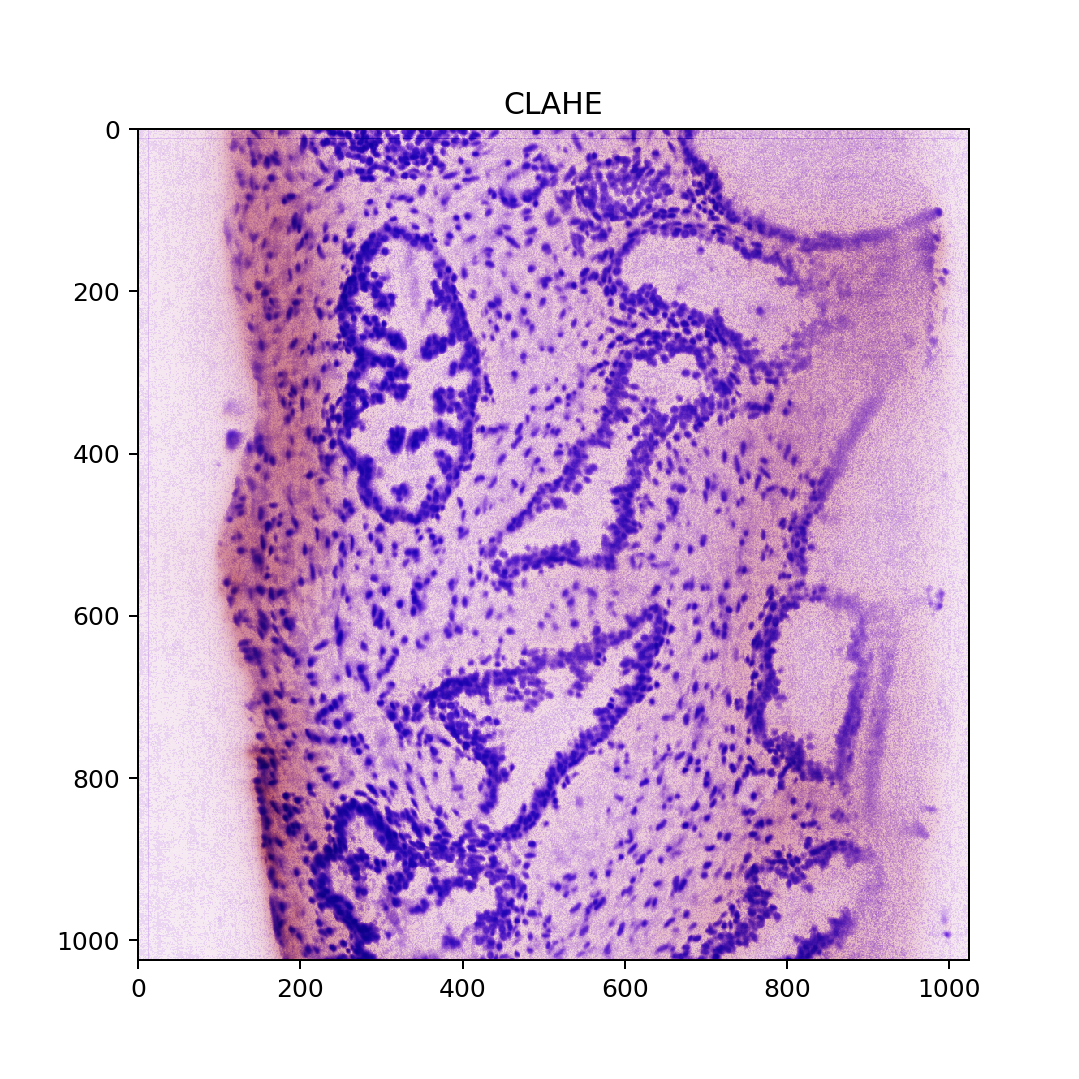

In [13]:
for i in range(10,30,20):
    ViewImage(pseudo_colored_raw[0,i],title='Raw',figsize=(6,6))
    ViewImage(false_clahe[0,i],title='CLAHE',figsize = (6,6))

In [14]:
nuclei_tophat = testData.processImages(tophat_runnable,imageSet=copy.deepcopy(trial_nuclei))
nuclei_tophat.dtype

<function tophat_filter at 0x1c2ead97b8> {'size': 31} (40, 1025, 1025)


dtype('int16')

In [15]:
combined_tophat = np.stack((copy.deepcopy(nuclei_tophat[0]),copy.deepcopy(trial_cyto)),axis=-1)
print(combined_tophat.dtype)
pseudo_tophat = testData.processImages(falseColor_runnable,imageSet=combined_tophat)

int16
<function falseColor at 0x1c2ce0d158> {'channelIDs': ['s00', 's01']} (40, 1025, 1025, 2)


<IPython.core.display.Javascript object>


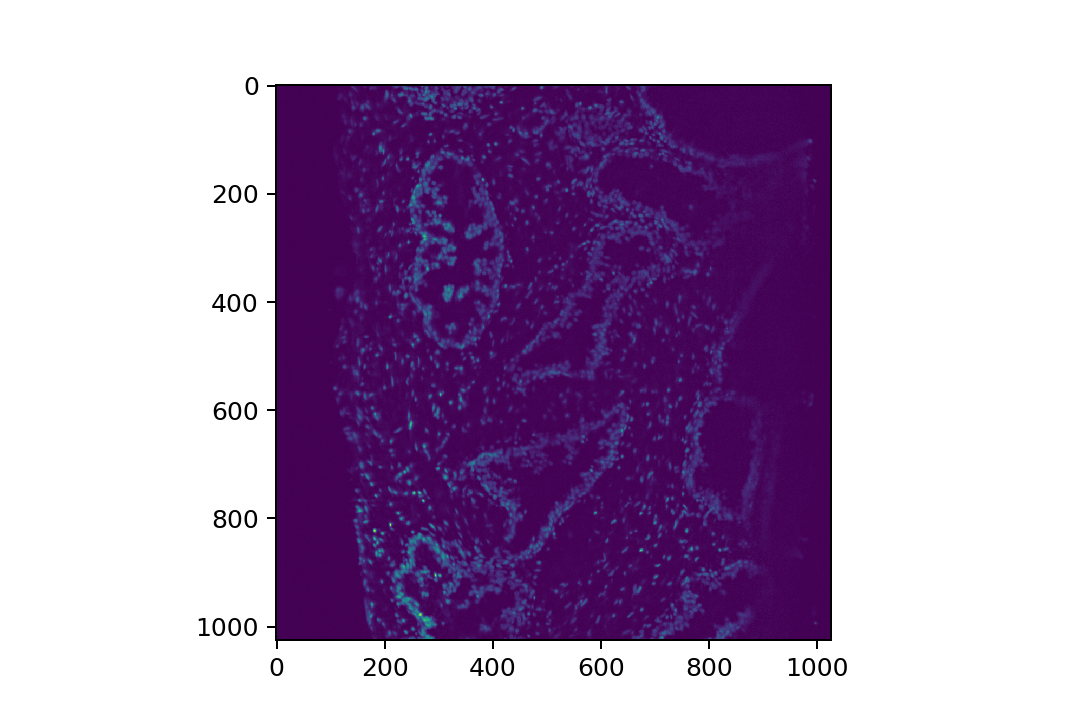

<IPython.core.display.Javascript object>


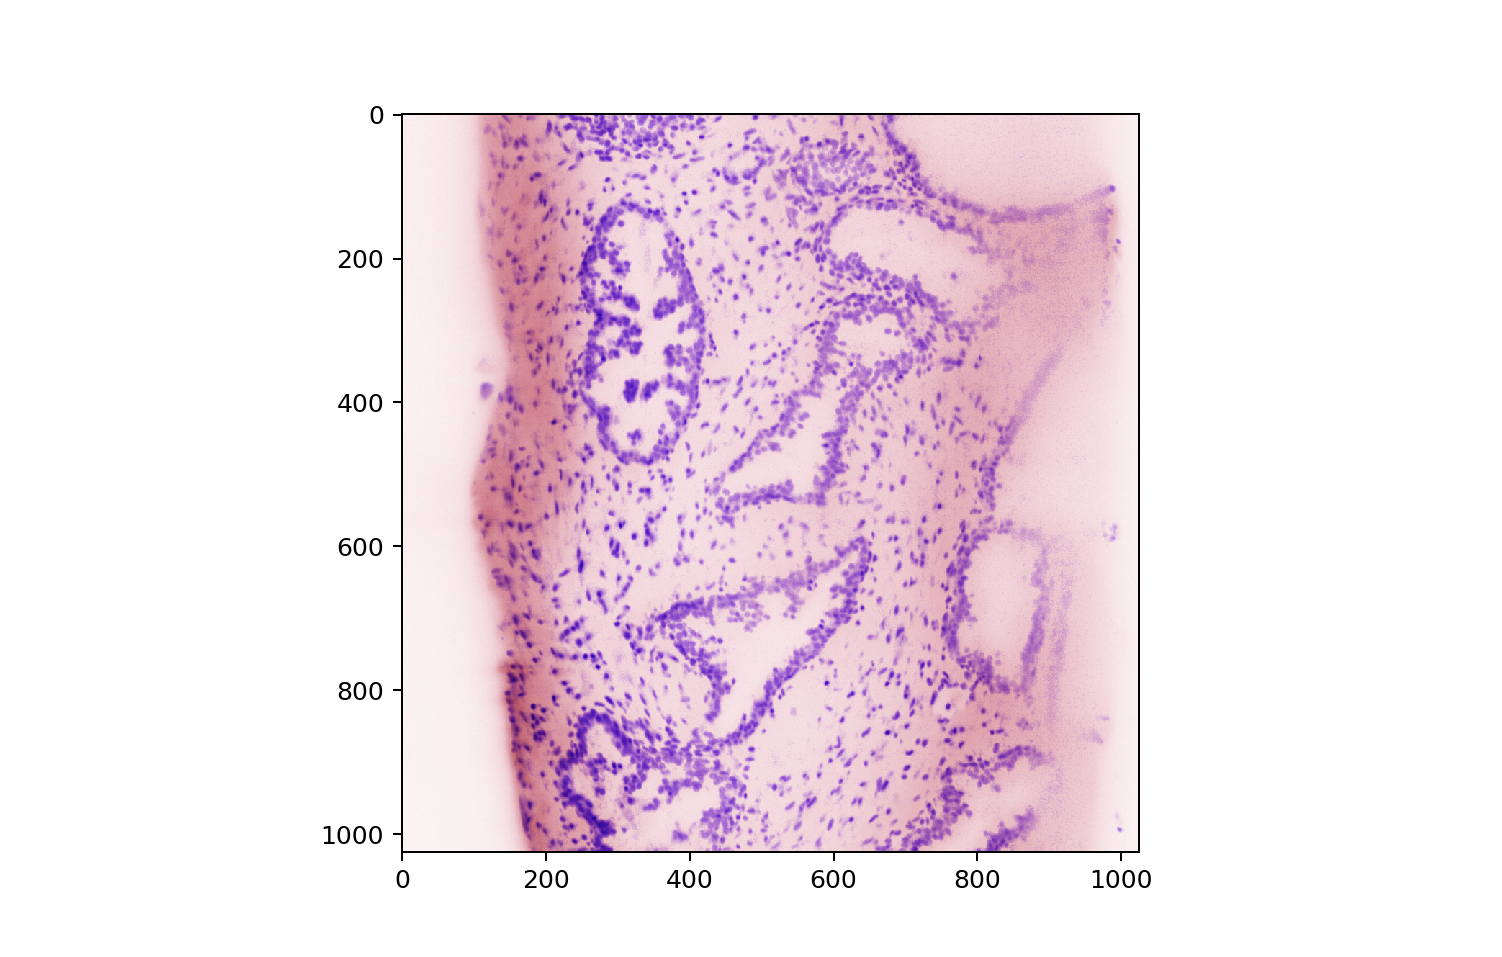

In [16]:
for i in range(10,20,10):
    ViewImage(nuclei_tophat[0,i])
    ViewImage(pseudo_tophat[0,i])

<IPython.core.display.Javascript object>


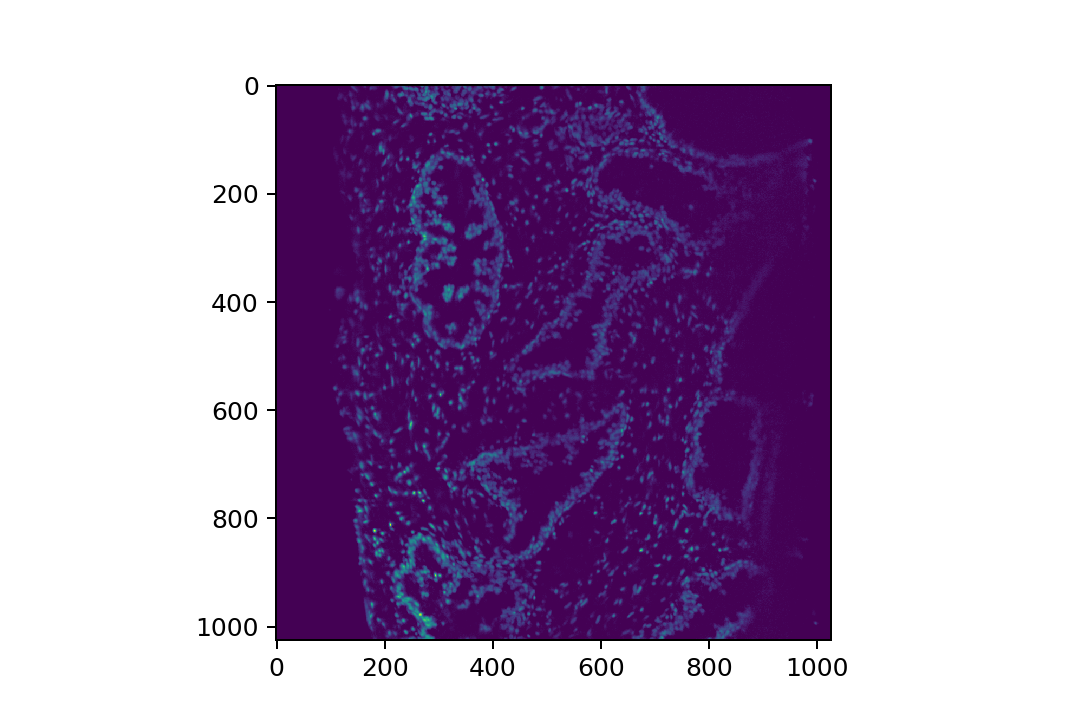

(<Figure size 600x400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1de711e7b8>)

In [46]:
testimg = copy.deepcopy(nuclei_tophat[0,10])
testimg1 = copy.deepcopy(nuclei_tophat[0,10])
ViewImage(preProcess(testimg,'s00'))

In [17]:
cyto_equalized = testData.processImages(filter_equal_runnable,imageSet=trial_cyto)

<function filter_and_equalize at 0x1c2c34a0d0> None (40, 1025, 1025)


In [ ]:
for i in range(1,6):
    z=tophat_filter(trial_cyto[i])
    z[z<=30] = np.median(z)
#     ex.equalize_adapthist(z,kernel_size=204)
    ViewImage(z)

In [19]:
plt.close('all')

In [ ]:
z1 = filt.median(trial_cyto[10])
ViewImage(z1)

In [ ]:
import skimage.util as util
filter_trial = np.zeros(trial_set.shape,dtype=np.int16)
for i,z in enumerate(trial_set):
    filter_trial[i] = util.img_as_uint(tophat_filter(z))
    

In [ ]:
test_block = blocks[16]
testimg = filt.median(test_block[1],selem=morph.disk(3))
norm_test = ex.equalize_adapthist(testimg,kernel_size=40)
ViewImage(norm_test,do_hist=True)

In [ ]:
blocks=make_blocks_vectorized(filter_trial,205)

In [5]:
def ravel_falseColor(imageSet,channelIDs=['s00','s01'],output_dtype= np.uint8):
    """
    expects input imageSet data to be structured in the same way as in the FCdataobject

    """
    # print(type(imageSet))

    beta_dict = {'cytoplasm' : {'K' : 0.008,
                              'R' : 0.300,
                              'G' : 1.000,
                              'B' : 0.860,
                              'thresh' : 500},
                's01' : {'K' : 0.008,
                              'R' : 0.350,
                              'G' : 1.0,
                              'B' : 0.860,
                              'thresh' : 500},
                 'nuclei' : {'K' : 0.017,
                             'R' : 0.544,
                             'G' : 1.000,
                             'B' : 0.30,
                             'thresh' : 50},
                's00' : {'K' : 0.017,
                             'R' : 0.544,
                             'G' : 1.000,
                             'B' : 0.10,
                             'thresh' : 50}}

    constants_nuclei = beta_dict[channelIDs[0]]
    k_nuclei = constants_nuclei['K']

    constants_cyto = beta_dict[channelIDs[1]]
    k_cytoplasm= constants_cyto['K']
     
    nuclei = fc.preProcess(imageSet[:,:,0].ravel(),channelIDs[0])
    nuclei = np.reshape(nuclei,imageSet[:,:,0].shape)
    cyto = fc.preProcess(imageSet[:,:,1].ravel(),channelIDs[1])
    cyto = np.reshape(cyto,imageSet[:,:,1].shape)

    RGB_image = np.zeros((nuclei.shape[0],nuclei.shape[1],3))
      
    R = np.multiply(np.exp(-constants_cyto['R']*k_cytoplasm*cyto),
                                    np.exp(-constants_nuclei['R']*k_nuclei*nuclei))

    G = np.multiply(np.exp(-constants_cyto['G']*k_cytoplasm*cyto),
                                    np.exp(-constants_nuclei['G']*k_nuclei*nuclei))

    B = np.multiply(np.exp(-constants_cyto['B']*k_cytoplasm*cyto),
                                    np.exp(-constants_nuclei['B']*k_nuclei*nuclei))

    RGB_image[:,:,0] = (R*255)
    RGB_image[:,:,1] = (G*255)
    RGB_image[:,:,2] = (B*255)
    return RGB_image.astype(output_dtype)

ravelfalseColor_runnable = {'runnable' : ravel_falseColor, 'kwargs' : {'channelIDs':channelIDs}}